# News Article web scraping and then category classification

In this project, we are focusing on the data provided at : http://mlg.ucd.ie/modules/COMP41680/assignment2/index.html 
Our intention here is to scrape the data and then store it in appropriate format and then carry out given instructions. We will use Beautiful Soup to do it and as always we first import required modules and then we will do a html request.

### Important Note: Some of the sections in data scraping section have been commented as they are raw and really large. Please uncomment those 

In [1]:
#importing all the relevant modules required throughout the notebook. Some other packages have also been imported wherever necessary along the code
import requests
import time
import csv
import re
from bs4 import BeautifulSoup
import pandas as pd
import io
import calendar
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

# Task 1: Scraping the data and storing it in appropriate format

Importing has been successfully done. Now we start with scraping the data available. At first we will import just one webpage and then examine all the html tags in there so that we can write appropriate functions to scrape them in one go.

In [2]:
url="http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-001.html" #first webpage of january
# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text 
soup = BeautifulSoup(html_content, "lxml") #using beautiful soup 
print(soup.prettify()) # print the parsed data of html


<!DOCTYPE html>
<html lang="en">
 <head>
  <meta content="noindex" name="robots"/>
  <meta content="Content on this site is posted for teaching purposes only. Original data is from theguardian.com" name="description"/>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <title>
   News Archive January 2020
  </title>
  <link href="images/favicon.ico" rel="shortcut icon"/>
  <!-- Bootstrap core CSS -->
  <link href="assets/css/bootstrap.css" rel="stylesheet"/>
  <!-- Custom styles for this template -->
  <link href="assets/css/style.css" rel="stylesheet"/>
  <link href="assets/css/font-awesome.min.css" rel="stylesheet"/>
  <script src="assets/js/modernizr.js">
  </script>
 </head>
 <body>
  <div class="container mtb">
   <div class="jumbotron">
    <h1>
     <a href="index.html">
      News Archive
     </a>
    </h1>
    <p>
     Article collection — January 2020
    </p>
   </div>


The entire information for one story is present inside an 'article' tag so we will examine its contents separately especially focusing on its children tags(tags nested inside it).

In [3]:
article=soup.find('div',class_='article') #finding first tag named article
print(article)
print(list(article.children)) #printing nested tags inside article tag

<div class="article"><h5>1. <a href="https://www.theguardian.com/uk-news/2020/jan/01/lets-resolve-to-reconnect-says-welby-in-new-year-message" target="_blank">Let's resolve to reconnect, says Welby in new year message</a></h5><p class="metadata">Wed 1 Jan 2020 00:01 GMT</p><p class="metadata">Category: <span>UK-News</span></p><p class="snippet">The archbishop of Canterbury will urge people to make personal connections with others in 2020 to create a new unity in a divided society. In his new …</p></div>
[<h5>1. <a href="https://www.theguardian.com/uk-news/2020/jan/01/lets-resolve-to-reconnect-says-welby-in-new-year-message" target="_blank">Let's resolve to reconnect, says Welby in new year message</a></h5>, <p class="metadata">Wed 1 Jan 2020 00:01 GMT</p>, <p class="metadata">Category: <span>UK-News</span></p>, <p class="snippet">The archbishop of Canterbury will urge people to make personal connections with others in 2020 to create a new unity in a divided society. In his new …</p>]


We notice that headline is under a text tag inside an a tag inside a h5 tag inside article tag. Similarly tag paths for category and snippets were identified and now we will verify the same.

In [4]:
#verifying data present inside identified tags
headline=article.h5.a.text 
print(headline)
category=article.span.text
print(category)
snippet=list(article.children)[3].text
print(snippet)

Let's resolve to reconnect, says Welby in new year message
UK-News
The archbishop of Canterbury will urge people to make personal connections with others in 2020 to create a new unity in a divided society. In his new …


As we can see the required information that we need to store was printed. So, now we need to get the same info from all the 'article' tags in all the consecutive webpages and write them into a csv file. This has to be done methodically by calling one function inside the other. Lets first check if we are able to categorize all the info from all the stories from the soup we just parsed then we will go for entire dataset.

In [5]:
for article in soup.find_all('div',class_='article'): #going through all tags named article one by one
    headline=article.h5.a.text
    print(headline)
    category=list(article.children)[2].text.split(": ")
    category=category[1]
    print(category)
    snippet=list(article.children)[3].text
    print(snippet)
    print() #keeping a gap line between two stories

Let's resolve to reconnect, says Welby in new year message
UK-News
The archbishop of Canterbury will urge people to make personal connections with others in 2020 to create a new unity in a divided society. In his new …

Be honest. You're not going to read all those books on your holiday, are you?
Books
Every year, about this time, my Instagram feed fills up with pictures of books. Theyâre piled somewhere between five and ten inches high, sometimes st …

Mariah Carey's Twitter account hacked on New Year's Eve
Music
Mariah Careyâs Twitter account appeared to have been hacked late Tuesday afternoon, sharing numerous racist slurs and comments with the singerâs 21.4 …

The joy audit: how to have more fun in 2020
Life-and-Style
The last time I felt joy was at an event that would be many peopleâs vision of hell: a drunken Taylor Swift club-night singalong in the early hours of …

Providence Lost by Paul Lay review â the rise and fall of Oliver Cromwellâs Protectorate
Books
The onl

Now lets write a function scrape that will collect the same information from the soup of a given webpage.

In [6]:
def scrape(source_url, soup):  # Takes the driver and the subdomain for concats as params
    # Find the elements of the article tag
    news = soup.find_all('div',class_='article')

    # Iterate over each book article tag
    for article in news:
        headline=article.h5.a.text
        category=list(article.children)[2].text.split(": ")
        category=category[1]
        snippet=list(article.children)[3].text
        # Invoke the write_to_csv function
        if category=='UK-News' or category == 'Books' or category == 'Music':
            write_to_csv([category,headline, snippet])

Next, we write a function with appropriate encoding that writes a list passed into it into a csv file where data will be dumped.

In [7]:
def write_to_csv(list_input):
    # The scraped info will be written to a CSV here.
    try:
        with open("allnews.csv", "a",encoding="utf-7") as fopen:  # Open the csv file.
            csv_writer = csv.writer(fopen)
            csv_writer.writerow(list_input)
    except:
        return False

Next, we write a function that will jump to the next webpage whose link is inside the 'next' button in the end of the webpage so that the entire data for one month can be collected in one go.

In [8]:
def browse_and_scrape(seed_url,url):
    try:
        html_text = requests.get(url).text
        soup = BeautifulSoup(html_text, "lxml")
        z= soup.find_all("a", class_="page-link") #checking if there is a next page
        if len(z)>3:
            elem=z[2] # finding the right tag for next page link
        else:
            return
        if (elem["href"]) != None:
            url=seed_url+elem["href"]
            scrape(url, soup)     # Invoke the scrape function
            browse_and_scrape(seed_url, url)
        else:
            scrape(source_url, soup)     # The script exits here
            return True
        return True
    except Exception as e:
        return e

Finally we pass the column names to the csv file and start dumping data in the pattern followed by the url so that web scraping can be done in just one instance and then we store the csv file. This marks the end of Task 1. The three chosen categories are UK News, Books and Music. For the entire length of this notebook several inputs have been carried out using 1 for UK news, 2 for Music and 3 for Books. 

In [9]:
write_to_csv(['Category','Title','Snippet'])
month_value = range(1,13)
mon = [calendar.month_name[i] for i in month_value]
for i in mon:
    url = "http://mlg.ucd.ie/modules/COMP41680/assignment2/month-"+i[0:3].lower()+"-001.html" #generating the right url format
    seed_url = "http://mlg.ucd.ie/modules/COMP41680/assignment2/"
    print("Web scraping has begun for the month:"+i)
    result = browse_and_scrape(seed_url,url)
    if result == True:
        print("Web scraping is now complete  for the month:"+i)
    else:
        print(f"Oops, That doesn't seem right!!! - {result}")

Web scraping has begun for the month:January
Web scraping is now complete  for the month:January
Web scraping has begun for the month:February
Web scraping is now complete  for the month:February
Web scraping has begun for the month:March
Web scraping is now complete  for the month:March
Web scraping has begun for the month:April
Web scraping is now complete  for the month:April
Web scraping has begun for the month:May
Web scraping is now complete  for the month:May
Web scraping has begun for the month:June
Web scraping is now complete  for the month:June
Web scraping has begun for the month:July
Web scraping is now complete  for the month:July
Web scraping has begun for the month:August
Web scraping is now complete  for the month:August
Web scraping has begun for the month:September
Web scraping is now complete  for the month:September
Web scraping has begun for the month:October
Web scraping is now complete  for the month:October
Web scraping has begun for the month:November
Web scra

The code shows the month for which the scraping is in progress one by one and it ends at december. This is done to progress the flow of code as scraping takes a significant time.

# Task 2: Binary Classification

We start by opening the saved csv file and analyzing the columns present and info present inside it

In [10]:
rawdf = pd.read_csv("allnews.csv")
print(rawdf.head())
rawdf.Category.value_counts()

  Category  ...                                            Snippet
0  UK-News  ...  The archbishop of Canterbury will urge people ...
1    Books  ...  Every year, about this time, my Instagram feed...
2    Music  ...  Mariah Carey+AOIAgACZ-s Twitter account appear...
3    Books  ...  The only public execution of a British head of...
4    Books  ...  Matt Haig I have been very dark and gloomy wit...

[5 rows x 3 columns]


Books       7284
Music       7188
UK-News     7180
Category       3
Name: Category, dtype: int64

Next, we write a function to preprocess the data by converting all text into lowercase, removing any special characters and symbols and stop words including the word news.

In [11]:
def clean_text(text):
    text = text.lower() #converting to lower case
    text = special_character_remover.sub(' ', text) #replacing special characters with a space
    text = extra_symbol_remover.sub('', text) #replacing symbols with a space
    text = ' '.join(word for word in text.split() if word not in stopwords) #replacing stopwords with a space
    return text
rawdf.drop_duplicates(inplace=True) # removing duplicates
special_character_remover = re.compile('[/(){}\[\]\|@,;]')
extra_symbol_remover = re.compile('[^0-9a-z #+_]')
nltk.download('stopwords') #downloading as by default they are not present
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('news') #news is another word that should be considered as stopwords in our specific case
print(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

Next, we write a function that takes the dataframe from the csv file and one category as input and returns a filtered dataframe containing a tag and a combination of snippet and headline as input. This was specified as per Task 2 in the assignment brief. The function also carries out preprocessing and prints the change in word count because of it.

In [12]:
def individualdataframes(rawdf,category):
    df = rawdf.loc[rawdf['Category'] == category].copy() #creating a copy so that slice issue is not there
    df.reset_index(drop=True, inplace=True) #reseting the index
    df.index=df.index+1 
    df['input'] = df['Title'] +" "+ df['Snippet'] #combining title and snippet and then we drop remaining columns
    del df['Title']
    del df['Snippet']
    del df['Category']
    if category=='UK-News': #adding a tag column 0-UK News, 1-Music and -1 - books
        df['Tag'] = [0]*len(df)
    elif category=='Music':
        df['Tag'] = [1]*len(df)
    elif category == 'Books':
        df['Tag'] = [-1]*len(df)
    else:
        return "Thats a rip"
    print('Word count before cleaning:')
    print(df['input'].apply(lambda x: len(x.split(' '))).sum())
    df['input'] = df['input'].apply(clean_text)
    df.drop_duplicates(inplace=True)
    special_character_remover = re.compile('[/(){}\[\]\|@,;]')
    extra_symbol_remover = re.compile('[^0-9a-z #+_]')
    print('Word count after cleaning:')
    print(df['input'].apply(lambda x: len(x.split(' '))).sum())
    return df

Next, we call the function individually for each category. This gives us three different dataframes specific to each category having unique tags and inputs

In [13]:
ruknews_doc=individualdataframes(rawdf,'UK-News')
print('We have a total of ',len(ruknews_doc),'dataset for UK News Category') #counting the number of rows for each category
rmusic_doc=individualdataframes(rawdf,'Music')
print('We have a total of ',len(rmusic_doc),'dataset for music News Category')
rbooks_doc=individualdataframes(rawdf,'Books')
print('We have a total of ',len(rbooks_doc),'dataset for books News Category')
raw_doc=ruknews_doc+rmusic_doc+rbooks_doc
print(raw_doc.head())

Word count before cleaning:
66547
Word count after cleaning:
42564
We have a total of  1795 dataset for UK News Category
Word count before cleaning:
67833
Word count after cleaning:
45069
We have a total of  1797 dataset for music News Category
Word count before cleaning:
70286
Word count after cleaning:
44168
We have a total of  1821 dataset for books News Category
                                               input  Tag
1  lets resolve reconnect says welby new year mes...  0.0
2  visa applications home office refuses reveal h...  0.0
3  victims nye surrey road crash ba cabin crew le...  0.0
4  man held suspicion double murder bodies found ...  0.0
5  antiislamic slogans spraypainted near mosque b...  0.0


Next, we create a function that based on the input pair which produces the documents for binary classification as per the requirements mentioned in the assignment brief. There is a combination of title and snippet marked as input and a tag describing which category in the pair does the data belong to.

In [14]:
def binaryclassificationdataframes(in1,in2):
    df = pd.DataFrame(columns = ['input', 'Tag'])
    if (in1==1 and in2==2): #making unique individual pairs
        df=pd.concat([ruknews_doc, rmusic_doc], ignore_index=True, sort=False)
    elif in1==2 and in2==3:
        df=pd.concat([rmusic_doc, rbooks_doc], ignore_index=True, sort=False)
        df['Tag']=(df['Tag']-1)/2 #calculations to ensure that tags are always 0 and 1
        df['Tag'] = df['Tag'].apply(np.int64)
        df['Tag'] = df['Tag'].abs()
    elif in1==3 and in2==1:
        df=pd.concat([rbooks_doc, ruknews_doc], ignore_index=True, sort=False)
        df['Tag']=(df['Tag']+1)
        df['Tag'] = df['Tag'].apply(np.int64)
    return df

Let us check the output of the function once.

In [15]:
print(binaryclassificationdataframes(2,3))

                                                  input  Tag
0     mariah careys twitter account hacked new years...    0
1     woodford folk festival review +aoiagact muchne...    0
2     tara erraught james baillieu review +aoiagact ...    0
3     something weird works tiktok write pop smash 2...    0
4     tracks week reviewed raye usher lil uzi vert r...    0
...                                                 ...  ...
3613  death francis bacon max porter review +aoiagac...    1
3614  eula biss review +aoiagact saturated capitalis...    1
3615  beginners tom vanderbilt review +aoiagact neve...    1
3616  humaning nice idea ridiculous corporate buzzwo...    1
3617  little scratch rebecca watson review daringly ...    1

[3618 rows x 2 columns]


Now that pre processing and paired dataset preparation is complete, we define a function that calls the previous one inside it and then goes for binary clsasification using keras model. The output is given in terms of accuracy score and confusion matrix.

In [16]:
def kerasmodel(in1,in2): #keras model training function
    df=binaryclassificationdataframes(in1,in2) #creating input dataset
    if (in1==1 and in2==2):
        print("Working on UK-News and Music")
        xtick=['UK-News','Music'] #creating labels for confusion matrix in each case
    elif in1==2 and in2==3:
        print("Working on Music and Books")
        xtick=['Music','Books']
    elif in1==3 and in2==1:
        print("Working on Books and UK-News ")
        xtick=['Books','UK-News']
    train=df.sample(frac=0.5,random_state=200) #random state is a seed value to produce same results every time
    test=df.drop(train.index) 
    training_sentences = train['input'].to_list() #converting to list as the functions accept list as input not dataframes
    training_labels = train['Tag'].to_list()
    test_sentences = test['input'].to_list()
    test_labels = test['Tag'].to_list()
    training_sentences_final = np.array(training_sentences) #converting to numpy arrays for easier manipulation
    test_sentences_final = np.array(test_sentences)
    training_labels_final = np.array(training_labels)
    test_labels_final = np.array(test_labels)
    #specifications for the model
    vocab_size=10000 #size of voacbulary
    embedding_dim = 16
    max_length = 120
    trunc_type ='post'
    oov_tokn = "<OOV>"
    tokenizer = Tokenizer(num_words = vocab_size, oov_token =oov_tokn ) #converting text to numeric representation
    tokenizer.fit_on_texts(training_sentences) #fitting the tokenizer
    word_index = tokenizer.word_index
    sequence = tokenizer.texts_to_sequences(training_sentences)
    padded = pad_sequences(sequence, maxlen = max_length, truncating =trunc_type ) #padding
    testing_sequence = tokenizer.texts_to_sequences(test_sentences)
    testing_padded = pad_sequences(testing_sequence, maxlen = max_length)
    model = keras.Sequential([ #generating the model
        keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss ='binary_crossentropy', optimizer='adam', metrics = ['accuracy']) #compilation
    model.fit(padded,
          training_labels_final,
          epochs = 5,
          validation_data = (testing_padded, test_labels_final)
         )
    y_predicted = model.predict(testing_padded) #predicting
    y_predicted = np.where(y_predicted > 0.5, 1, 0)
    cf_matrix = confusion_matrix(test_labels_final, y_predicted) #creating a confusion matrix
    sns.heatmap(cf_matrix, annot=True,xticklabels=xtick,yticklabels=xtick) #visualizing confusion matrix
    print('The accuracy is:',accuracy_score(test_labels_final, y_predicted)) #printing accuracy

Another model that we train in a similar fashion is the linear regression via a pipeline. Outputs are again the same. We will write another function for logistic regression model.

In [17]:
def binarylogregress(in1,in2):#logistic regression model training function
    df=binaryclassificationdataframes(in1,in2) #creating input dataset
    if (in1==1 and in2==2):
        print("Working on UK-News and Music")
        xtick=['UK-News','Music']  #creating labels for confusion matrix in each case
    elif in1==2 and in2==3:
        print("Working on Music and Books")
        xtick=['Music','Books']
    elif in1==3 and in2==1:
        print("Working on Books and UK-News ")
        xtick=['Books','UK-News']
    from sklearn.model_selection import train_test_split 
    X = df.input
    y = df.Tag
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42) #splitting into test and train subsets with random state for reporducibility
    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import Pipeline
    from sklearn.feature_extraction.text import TfidfTransformer
    lr = Pipeline([('vect', CountVectorizer()), #creating the pipleine of transforms
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression()),
                  ])

    lr.fit(X_train,y_train) #fitting the model
    y_pred1 = lr.predict(X_test) #predicting the model
    print(f"Accuracy of the model is : {accuracy_score(y_pred1,y_test)}") #accuracy score
    print('The confusion matrix of the model is:') #confusion matrix
    cf_matrix = confusion_matrix(y_pred1, y_test)
    sns.heatmap(cf_matrix, annot=True,xticklabels=xtick,yticklabels=xtick)

Now for each unique pair we call the kerasmodel function as well as the linear regression function and then we compare the results to conclude.

Working on UK-News and Music
Epoch 1/5
57/57 [==============================] - 2s 18ms/step - loss: 0.6814 - accuracy: 0.5535 - val_loss: 0.5115 - val_accuracy: 0.8090
Epoch 2/5
57/57 [==============================] - 1s 12ms/step - loss: 0.3262 - accuracy: 0.9034 - val_loss: 0.1752 - val_accuracy: 0.9304
Epoch 3/5
57/57 [==============================] - 1s 9ms/step - loss: 0.0194 - accuracy: 0.9971 - val_loss: 0.1497 - val_accuracy: 0.9421
Epoch 4/5
57/57 [==============================] - 1s 10ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1481 - val_accuracy: 0.9410
Epoch 5/5
57/57 [==============================] - 1s 9ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.9438
The accuracy is: 0.9437639198218263


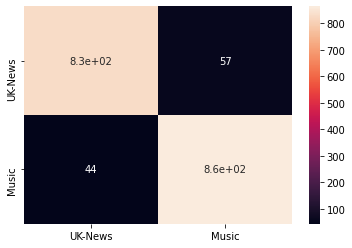

In [18]:
kerasmodel(1,2)

Working on Music and Books
Epoch 1/5
57/57 [==============================] - 1s 13ms/step - loss: 0.6958 - accuracy: 0.4678 - val_loss: 0.6906 - val_accuracy: 0.5102
Epoch 2/5
57/57 [==============================] - 1s 9ms/step - loss: 0.6190 - accuracy: 0.7278 - val_loss: 0.3653 - val_accuracy: 0.8519
Epoch 3/5
57/57 [==============================] - 1s 9ms/step - loss: 0.0651 - accuracy: 0.9918 - val_loss: 0.2969 - val_accuracy: 0.8756
Epoch 4/5
57/57 [==============================] - 1s 9ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.2930 - val_accuracy: 0.8762
Epoch 5/5
57/57 [==============================] - 1s 9ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2954 - val_accuracy: 0.8745
The accuracy is: 0.8745163073521283


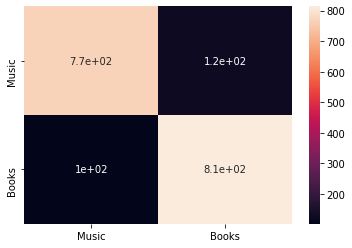

In [19]:
kerasmodel(2,3)

Working on Books and UK-News 
Epoch 1/5
57/57 [==============================] - 1s 13ms/step - loss: 0.6953 - accuracy: 0.4902 - val_loss: 0.6763 - val_accuracy: 0.6510
Epoch 2/5
57/57 [==============================] - 1s 9ms/step - loss: 0.5892 - accuracy: 0.7753 - val_loss: 0.2432 - val_accuracy: 0.9198
Epoch 3/5
57/57 [==============================] - 1s 10ms/step - loss: 0.0737 - accuracy: 0.9864 - val_loss: 0.2505 - val_accuracy: 0.9004
Epoch 4/5
57/57 [==============================] - 1s 9ms/step - loss: 0.0142 - accuracy: 0.9974 - val_loss: 0.1629 - val_accuracy: 0.9381
Epoch 5/5
57/57 [==============================] - 1s 10ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1693 - val_accuracy: 0.9458
The accuracy is: 0.9457964601769911


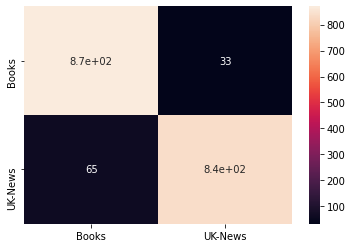

In [20]:
kerasmodel(3,1)

Working on UK-News and Music
Accuracy of the model is : 0.9489795918367347
The confusion matrix of the model is:


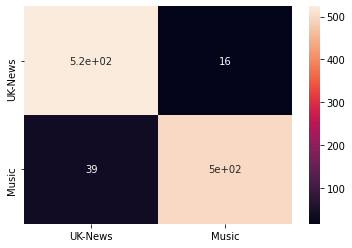

In [21]:
binarylogregress(1,2)

Working on Music and Books
Accuracy of the model is : 0.9088397790055248
The confusion matrix of the model is:


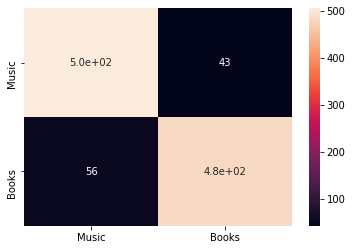

In [22]:
binarylogregress(2,3)

Working on Books and UK-News 
Accuracy of the model is : 0.9511520737327189
The confusion matrix of the model is:


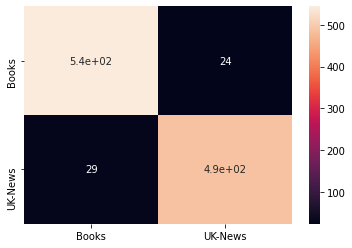

In [23]:
binarylogregress(3,1)

In Conclusion, both the models have shown good amount of accuracy although binary logistic regression has shown superior results overall. So now we write a function that can run a 100 instances of the same model and then we analyze the average accuracy. In principle this can also be done using a function called cross_val_score but we chose to write one of our own. The difference is our function doesn't follow a pattern amongst its different instances.

In [24]:
def binary_eval(in1,in2): #function for cross validation
  df=binaryclassificationdataframes(in1,in2)
  if (in1==1 and in2==2):
      print("Evaluating on UK-News and Music")
  elif in1==2 and in2==3:
      print("Evaluating on Music and Books")
  elif in1==3 and in2==1:
      print("Evaluating on Books and UK-News ")
  from sklearn.model_selection import train_test_split
  from sklearn.linear_model import LogisticRegression
  from sklearn.pipeline import Pipeline
  from sklearn.feature_extraction.text import TfidfTransformer
  import sys
  acc_score=[] # matrix for storing accuracy score for each instance
  c_mat=[] #matrix for storing confusion matrix for each instance
  X = df.input
  y = df.Tag
  for i in range(100):  #100 instances of random splitting and then fitting and predicting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    pipe = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', LogisticRegression()),
                  ])

    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    acc_score.append(accuracy_score(y_pred,y_test)) #appending accuracy score
    c_mat.append(confusion_matrix(y_pred,y_test)) #appending confusion matrix
    sys.stdout.write("\rPercentage done: %i " % (i+1)) #printing the state of the loop
    sys.stdout.flush() #flushing out to preserve console
  return(sum(acc_score)/100,sum(c_mat)/100)  #returning mean accuracy score and confusion matrix

The inputs can be changed as and when needed to ensure right combination of unique input categories are evaluated. 

Evaluating on UK-News and Music
Percentage done: 100 The average accuracy for 100 isntances is: 0.9465955473098333
The average confusion matrix for 100 instances is:


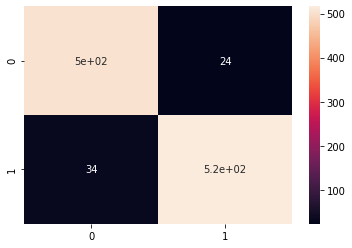

In [25]:
h=binary_eval(1,2)
print("The average accuracy for 100 isntances is:",h[0])
print('The average confusion matrix for 100 instances is:')
sns.heatmap(h[1], annot=True)

Evaluating on Music and Books
Percentage done: 100 The average accuracy for 100 isntances is: 0.9224861878453042
The average confusion matrix for 100 instances is:


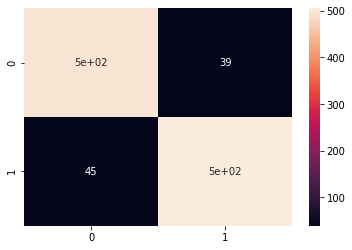

In [26]:
h=binary_eval(2,3)
print("The average accuracy for 100 isntances is:",h[0])
print('The average confusion matrix for 100 instances is:')
sns.heatmap(h[1], annot=True)

Evaluating on Books and UK-News 
Percentage done: 100 The average accuracy for 100 isntances is: 0.9433456221198155
The average confusion matrix for 100 instances is:


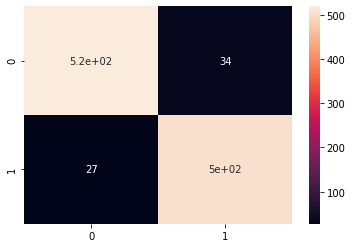

In [27]:
h=binary_eval(3,1)
print("The average accuracy for 100 isntances is:",h[0])
print('The average confusion matrix for 100 instances is:')
sns.heatmap(h[1], annot=True)

### Evaluation Results and Conclusion

So in case of Binary classification we evaluated using several appraoches including but not limited to cross validation, confusion matrix and accuracy score. Both the models trained have shown good results. Just so that the notebook doesnt become very lengthy we havent evaluated all the classifiers, just the one that showed better results. Otherwise an additional 3 combinations would have to be evaluated for three different unique pairs. In terms of single instance, keras model has shown an average accuracy of 92.426% where as logistic regression model has shown an average acuracy of 93.626%. When cross validating the individual accuracy for three unique pairs were 94.69%, 92.45% and 94.30%. These values are very high and raise the suspicion of overfitting. Just to be safe, we also verified the models using confusion matrix and we observed very high sensitivity and specificity which means overfitting isnt happening. Thus we can conclude that we have successfully completed all the steps for Task 2.

# **Task 3**: Multi class Classification

Initial steps in case of Multiple classification are same as Binary CLassification. We would read the CSV file, clean it up and prepare for multiple classification. We will again combine snippet and title into a single column marked input and the category column will work by itself as the tag. We drop any useless columns and confirm the three different categories.

In [28]:
df = pd.read_csv("allnews.csv") # converting the stored file from task 1 into a dataframe
df['input'] = df['Title'] +" "+ df['Snippet'] #combining title and snippet
del df['Title']
del df['Snippet']
print('Total number of categories:',len(df.Category.value_counts())) #counting unique values in categories column
print('They are:')
df.Category.unique() #printing unique values in categories column

Total number of categories: 4
They are:


array(['UK-News', 'Books', 'Music', 'Category'], dtype=object)

We will check for the presence of any duplicates just to be on the safe side.

In [41]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(5414, 2)
(5414, 2)


No duplicates present. Now lets check the word count of the corpus. This should drop considerably post pre processing which is something we have already observed in case of Binary Classification.

In [30]:
print(df['input'].apply(lambda x: len(x.split(' '))).sum(),'words in corpus') # counting number of words

204668 words in corpus


We carry out same preprocessing approach. We remove special characters as well as symbols and include the word 'news' in the nltk stopwords and then use it. We will just confifrm the same stopwords and then apply these steps on the corpus.

In [31]:
special_character_remover = re.compile('[/(){}\[\]\|@,;]') #removing special characters
extra_symbol_remover = re.compile('[^0-9a-z #+_]') #removing extra symbols
stopwords = nltk.corpus.stopwords.words('english') # stop words
stopwords.append('news')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Next, we make a function and apply those steps on the corpus.

In [32]:
def clean_text(text): #function for pre processing
    text = text.lower() #converting entire corpus to lowercase
    text = special_character_remover.sub(' ', text) #substituting with a space
    text = extra_symbol_remover.sub('', text)
    text = ' '.join(word for word in text.split() if word not in stopwords)
    return text
    

df['input'] = df['input'].apply(clean_text) # applying the preprocessing

Now that all the pre processing is done, we confirm the word count once again and then we start training the models. We would check three different models and compare their accuracy. We will use accuracy score and confusion matrix for it.

In [33]:
print(df['input'].apply(lambda x: len(x.split(' '))).sum(),'words in the corpus') #counting words

131803 words in the corpus


Now that is a reduction of a lot of words. But they were either words lost in encoding or stop words so they had to be removed. Otheriwse, they wouldnt have added any value to the algorithm and could have resulted in overfitting or bogus results. First, we start by splitting the dataset into training and testing. We use a random state number just to ensure we get same results every time. Later on we will run several instance of it without a random state numberso that we can evaluate uniformity but for now we do it just once.

In [34]:
from sklearn.model_selection import train_test_split
X = df.input
y = df.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 39) #splitting into testing set and training set
X_train.shape,X_test.shape,y_train.shape,y_test.shape #counts for each array

((3789,), (1625,), (3789,), (1625,))

Now we create a pipline have count vectorizer, tf idf transformer and then we go for logistic regression. Then we fit the data on to the pipeline and then lastly we compare the prediction with actual values using accuracy score and confusion matrix.

Confusion Matrix for Logistic Regression:
The accuracy of the model is: 0.9009230769230769


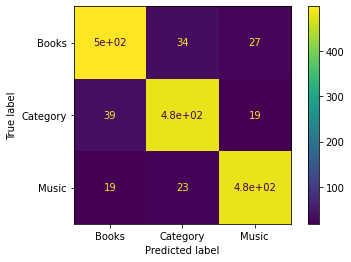

In [35]:
lr = Pipeline([('vect', CountVectorizer()), #pipeline for logistic regression
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])

lr.fit(X_train,y_train) #fitting
y_pred1 = lr.predict(X_test) #predicting

print("Confusion Matrix for Logistic Regression:")
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr,y_pred1,y_test) #confusion matrix
print('The accuracy of the model is:',accuracy_score(y_pred1,y_test)) 

Next we use Naive Bayes Multinomial Classification with a similar approach of the pipeline. We do the same thing again. We fit the data and then check for accuracy using confusion matrix and accuracy score.

Confusion Matrix for Logistic Regression:
The accuracy of the model is: 0.8941538461538462


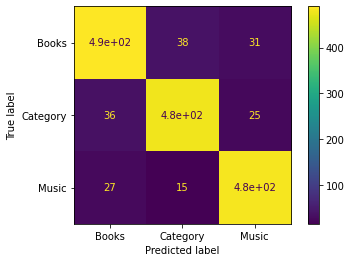

In [36]:
from sklearn.naive_bayes import MultinomialNB


naivebayes = Pipeline([('vect', CountVectorizer()), #naive bayes pipeline
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
naivebayes.fit(X_train, y_train) #pipeline

y_pred = naivebayes.predict(X_test) #prediction

print("Confusion Matrix for Logistic Regression:")
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(naivebayes,y_pred,y_test) #confusion matrix
print('The accuracy of the model is:',accuracy_score(y_pred,y_test)) 

Lastly we also use an xgboost classifier through the same pipelines approach.

Confusion Matrix for Logistic Regression:
The accuracy of the model is: 0.8006153846153846


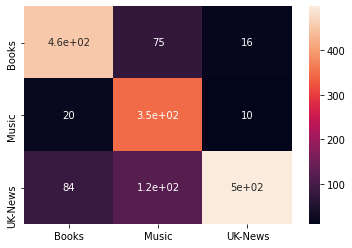

In [37]:
from xgboost import XGBClassifier

xgboost = Pipeline([('vect', CountVectorizer()), #pipeline for xgboost classifier
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier()),
              ])
xgboost.fit(X_train, y_train) #fitting

y_pred = xgboost.predict(X_test) #prediction
print("Confusion Matrix for Logistic Regression:")
sns.heatmap(confusion_matrix(y_pred,y_test), annot=True, xticklabels=['Books','Music','UK-News'],yticklabels=['Books','Music','UK-News']) #confusion matrix
print('The accuracy of the model is:',accuracy_score(y_pred,y_test)) 

Now we need to evaluate our model accuracy for the models that we trained.ALthough we did verify it using evaluation matrices and accuracy score, a better approach is to check several folds of the data. This can either be done using scores function or we could manually write a function of our own. We will do the later. We use the same approach as evaluation of Binary Classifiers. We train 100 instances of the same data and then take an average of the accuracy over these 100 instances. We write a function that evaluates it for us and then we run the function for some of the pipelines.

In [62]:
def evaluation_multi(in1): #function for cross validation of multi class classification
  from sklearn.model_selection import train_test_split
  from sklearn.naive_bayes import MultinomialNB
  from xgboost import XGBClassifier
  import sys
  acc_score=[] #matrix for storing accuracy score of each instance
  if in1 == 1: #checking which classifior to use based on input
    pipe = Pipeline([('vect', CountVectorizer()), #pipeline for logistic regression
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])
  elif in1 == 2:
    pipe = Pipeline([('vect', CountVectorizer()), #pipleine for Naive Bayes classifier
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
  elif in1 == 3:
    pipe = Pipeline([('vect', CountVectorizer()), #pipeline for XGBoost classifier
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier()),
              ])
  for i in range(100): #running 100 instance
    X = df.input
    y = df.Category
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc_score.append(accuracy_score(y_pred,y_test))
    sys.stdout.write("\rPercentage done: %i " % (i+1))
    sys.stdout.flush()
  return(sum(acc_score)/100)




Now we run the function and observe average accuracies for multiple classes using Naive Bayes Classifier. The input can be changed to evaluate other classifiers as well. 

In [63]:
h=evaluation_multi(2)
print('The average accuracy over 100 instances is:',h)

Percentage done: 100 The average accuracy over 100 instances is: 0.9029468242245196


### Evaluation Results and Conclusion

We carried out Multi-Class text classification using several classifiers like Logistic Regression, Naive Bayes Classifier and Xg Boost classifier. For one random set they produced an accuracy of 90%,89% and 80%. But, the training time for Logistic Regression was almost twice as that of Naive Bayes and the training time of XgBoost was almost 10 times which made Naive Bayes our choice for best classifier. Next when we cross validated it over 100 instances the average accuracy was reported to be 88%, this figure may change slightly with each time the code is run. None of the models showed any major overfitting issues and had fairly good specificity and sensitivity although XgBoost did show some concerns by classifying some of the music dataset as UK News.

# Conclusion

In this file we have carried out Binary Classification and Multi Class classification on the given webpage as per the assignment brief. Overall accuracy was higher in Binary classificaiton as compared to Multi Class classification. This can be attributed to more number of classes and much bigger dataset. Furthermore, we didnt obeserve any overfitting which was confirmed by confusion matrices for various cases. All models have reported high accuracy in general which could be attributed to very large dataset and good preprocessing. The CSV file is available in the zip file uploaded. The entire coad takes approximately 17 minutes and 31 seconds to run. 80% of this is the traning time for xgboost classifier for multi class classification